In [1]:
from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI


In [2]:
import numpy as np
import sys
import json
import pandas as pd


In [3]:
data_path = "Sample_PPG_MAT_125Hz.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

In [4]:
# Load the raw PPG signal
signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)
signal.v = signal.v [0:120*signal.fs] # 120 second long signal to be analysed

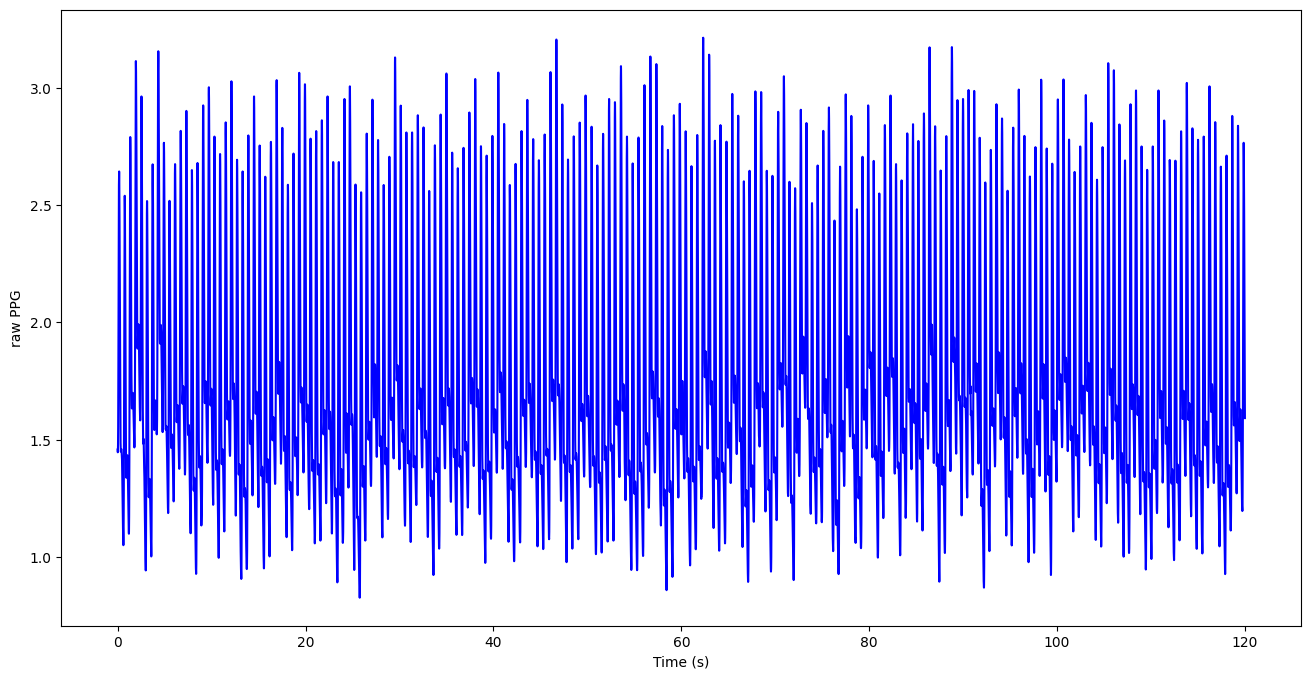

In [5]:
# import plotting package
from matplotlib import pyplot as plt

# setup figure
fig, ax = plt.subplots(figsize=(16, 8)) 

# create time vector
t = np.arange(0, len(signal.v))/signal.fs

# plot raw PPG signal
ax.plot(t, signal.v, color = 'blue')
ax.set(xlabel = 'Time (s)', ylabel = 'raw PPG')

# show plot
plt.show()

In [6]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=12 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

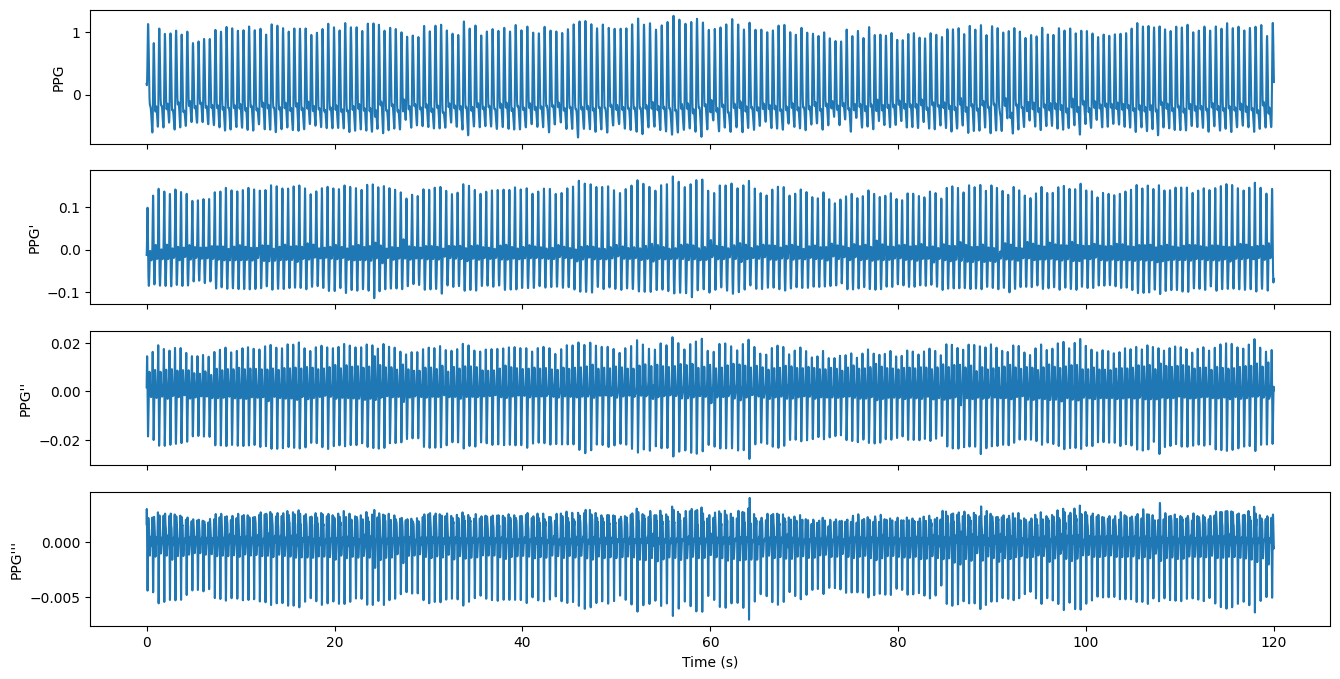

In [7]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1,figsize=(16,8), sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()

In [8]:
# Initialise the correction for fiducial points
corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Create a PPG class
s = PPG(signal)

In [9]:
#Initialise the fiducials package
fpex = FP.FpCollection(s=s)

In [10]:
#Extract fiducial points
fiducials = fpex.get_fiducials(s=s)

In [11]:
#Display the results
print("Fiducial points:\n",fiducials + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)

Fiducial points:
                    on     sp     dn     dp    off      u      v      w      a  \
Index of pulse                                                                  
0                   0     19     42     47     75     12     28     46      5   
1                  75     95    116    128    149     86    103    120     79   
2                 149    168    194    198    223    159    176    195    153   
3                 223    243    265    277    298    235    251    269    228   
4                 298    318    341    346    372    309    326    342    303   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
183             13829  13850  13872  13884  13905  13841  13858  13876  13834   
184             13905  13926  13948  13958  13980  13917  13933  13951  13911   
185             13980  14000  14022  14032  14054  13991  14008  14025  13985   
186             14054  14075  14098  14106  14129  14066  14083  14100  14059   
187       

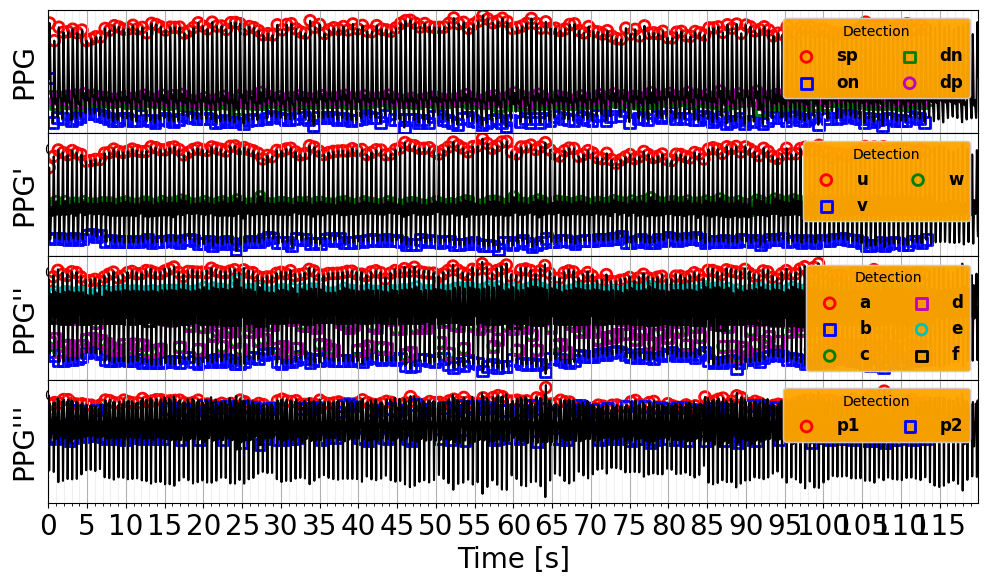

Figure has been saved in the "temp_dir".


In [12]:
# Create a fiducials class
fp = Fiducials(fp=fiducials)

# Plot fiducial points
plot_fiducials(s, fp, savingfolder, legend_fontsize=12)

In [13]:
# Get PPG SQI
ppgSQI = round(np.mean(SQI.get_ppgSQI(ppg=s.ppg, fs=s.fs, annotation=fp.sp)) * 100, 2)
print('Mean PPG SQI: ', ppgSQI, '%')

Mean PPG SQI:  98.63 %


In [14]:
# Init the biomarkers package
bmex = BM.BmCollection(s=s, fp=fp)

# Extract biomarkers
bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()
tmp_keys=bm_stats.keys()
print('Statistics of the biomarkers:')
for i in tmp_keys: print(i,'\n',bm_stats[i])

# Create a biomarkers class
bm = Biomarkers(bm_defs=bm_defs, bm_vals=bm_vals, bm_stats=bm_stats)

Statistics of the biomarkers:
ppg_sig 
                     Tpi       Tpp      Tsys      Tdia       Tsp       Tdp  \
Statistics                                                                  
mean           0.604696  0.604696  0.343217  0.188217  0.161087  0.416478   
median         0.600000  0.600000  0.344000  0.184000  0.160000  0.416000   
std            0.014137  0.013482  0.009255  0.015513  0.005767  0.013006   
percentile_25  0.592000  0.592000  0.336000  0.176000  0.160000  0.408000   
percentile_75  0.616000  0.608000  0.352000  0.192000  0.168000  0.424000   
iqr            0.024000  0.016000  0.016000  0.016000  0.008000  0.016000   
skew           0.591850  0.847619 -0.040588  1.119445  0.051801 -0.824934   
kurtosis      -0.192767  0.305906 -0.374087  1.334496  0.430537  2.887704   
mad            0.011590  0.010802  0.007195  0.012072  0.004192  0.009523   

                 deltaT     Tsw10         Tsw25         Tsw33  ...     Tpw66  \
Statistics                      

In [15]:
# Save PPG struct, fiducial points, biomarkers
fp_new = Fiducials(fp.get_fp() + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)
save_data(s=s, fp=fp_new, bm=bm, savingformat=savingformat, savingfolder=savingfolder)

Results have been saved into the "temp_dir".


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
fudpoint = pd.read_csv('temp_dir/Fiducial_points/_Fiducials_btwn_0-15001.csv')
fudpoint.head()

,Index of pulse,on,sp,dn,dp,off,u,v,w,a,b,c,d,e,f,p1,p2
0,1,0,19,42,47,75,12,28,46,5,17,22,22,36,57,22,41
1,2,75,95,116,128,149,86,103,120,79,92,98,98,111,130,98,116
2,3,149,168,194,198,223,159,176,195,153,165,169,169,184,204,169,189
3,4,223,243,265,277,298,235,251,269,228,240,245,245,260,279,245,265
4,5,298,318,341,346,372,309,326,342,303,315,320,320,334,345,320,339


In [18]:
fudpoint.describe()

,Index of pulse,on,sp,dn,dp,off,u,v,w,a,b,c,d,e,f,p1,p2
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,94.500000,7082.250000,7102.388298,7125.143617,7134.351064,7157.813830,7093.702128,7110.803191,7128.015957,7087.127660,7099.228723,7106.739362,7106.739362,7118.425532,7136.191489,7104.345745,7116.611702
std,54.415071,4133.615427,4133.667524,4133.249387,4133.671487,4133.302401,4133.638898,4133.562087,4133.396962,4133.590028,4133.649602,4133.700639,4133.700639,4133.467470,4133.293458,4133.741263,4133.180296
min,1.000000,0.000000,19.000000,42.000000,47.000000,75.000000,12.000000,28.000000,46.000000,5.000000,17.000000,22.000000,22.000000,36.000000,57.000000,22.000000,41.000000
25%,47.750000,3501.500000,3522.250000,3545.000000,3553.500000,3577.000000,3513.250000,3530.250000,3547.250000,3506.500000,3518.500000,3527.500000,3527.500000,3538.000000,3554.500000,3523.750000,3532.000000
50%,94.500000,7108.000000,7128.500000,7151.000000,7161.000000,7187.000000,7119.500000,7137.000000,7154.000000,7113.500000,7125.500000,7133.500000,7133.500000,7144.500000,7161.000000,7130.500000,7142.500000
75%,141.250000,10653.500000,10673.250000,10695.500000,10704.250000,10727.500000,10664.500000,10681.750000,10698.250000,10657.500000,10669.500000,10680.250000,10680.250000,10689.500000,10706.750000,10674.250000,10680.250000
max,188.000000,14129.000000,14150.000000,14173.000000,14183.000000,14206.000000,14141.000000,14159.000000,14176.000000,14135.000000,14147.000000,14152.000000,14152.000000,14167.000000,14186.000000,14152.000000,14173.000000


In [19]:
consicutive_peaks = fudpoint['sp']
print(consicutive_peaks)

0         19
1         95
2        168
3        243
4        318
       ...  
183    13850
184    13926
185    14000
186    14075
187    14150
Name: sp, Length: 188, dtype: int64


In [20]:
biomarkers = pd.read_csv('temp_dir\Biomarker_vals\_ppg_sig_btwn_0-15001.csv')
biomarkers.head()

,Index of pulse,Tpi,Tpp,Tsys,Tdia,Tsp,Tdp,deltaT,Tsw10,Tsw25,...,Tpw66,Tpw75,Tpw90,Asp,Adn,Adp,Aoff,AUCpi,AUCsys,AUCdia
0,1,0.600,0.608,0.336,0.224,0.152,0.376,0.224,0.096,0.080,...,0.128,0.112,0.064,0.953107,-0.323789,-0.638869,-0.778619,-1.200991,-0.164927,-1.036065
1,2,0.592,0.584,0.328,0.168,0.160,0.424,0.264,0.120,0.096,...,0.120,0.104,0.064,1.426741,0.335085,0.097725,0.092204,-1.634859,1.018460,-2.653319
2,3,0.592,0.600,0.360,0.200,0.152,0.392,0.240,0.112,0.096,...,0.128,0.112,0.072,1.567309,0.337815,0.049017,-0.011614,0.621487,1.617477,-0.995990
3,4,0.600,0.600,0.336,0.168,0.160,0.432,0.272,0.112,0.096,...,0.120,0.104,0.064,1.493988,0.289888,0.082749,0.077607,-2.724979,0.460545,-3.185524
4,5,0.592,0.592,0.344,0.208,0.160,0.384,0.224,0.112,0.096,...,0.128,0.104,0.064,1.424095,0.196018,-0.036259,-0.111914,2.452753,2.247311,0.205442


In [21]:
biomarkers.describe()

,Index of pulse,Tpi,Tpp,Tsys,Tdia,Tsp,Tdp,deltaT,Tsw10,Tsw25,...,Tpw66,Tpw75,Tpw90,Asp,Adn,Adp,Aoff,AUCpi,AUCsys,AUCdia
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,...,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,92.500000,0.604696,0.604696,0.343217,0.188217,0.161087,0.416478,0.255391,0.116652,0.096043,...,0.128478,0.106957,0.064609,1.561587,0.300923,0.036072,-0.004588,4.953248,3.410860,1.542388
std,53.260367,0.014176,0.013519,0.009280,0.015555,0.005782,0.013042,0.011988,0.004610,0.003878,...,0.005495,0.004537,0.003594,0.128506,0.080572,0.085447,0.089654,40.461193,17.840727,22.624419
min,1.000000,0.576000,0.576000,0.320000,0.168000,0.144000,0.352000,0.184000,0.096000,0.080000,...,0.112000,0.096000,0.056000,0.953107,-0.323789,-0.638869,-0.778619,-495.975177,-218.001496,-277.973682
25%,46.750000,0.592000,0.592000,0.336000,0.176000,0.160000,0.408000,0.248000,0.112000,0.096000,...,0.128000,0.104000,0.064000,1.480061,0.263587,-0.001959,-0.041374,4.179549,3.120270,1.005882
50%,92.500000,0.600000,0.600000,0.344000,0.184000,0.160000,0.416000,0.256000,0.120000,0.096000,...,0.128000,0.104000,0.064000,1.572405,0.304401,0.041518,-0.009175,8.394648,4.910219,3.433168
75%,138.250000,0.616000,0.608000,0.352000,0.192000,0.168000,0.424000,0.264000,0.120000,0.096000,...,0.128000,0.112000,0.064000,1.651482,0.342353,0.088087,0.042897,10.987445,6.031222,4.883501
max,184.000000,0.640000,0.648000,0.368000,0.248000,0.176000,0.448000,0.280000,0.128000,0.112000,...,0.144000,0.120000,0.072000,1.896880,0.488933,0.214837,0.202511,121.167658,53.415925,67.751733


In [22]:
ibi = pd.DataFrame({'IBI' : consicutive_peaks}).diff()
ibi.head()

,IBI
0,NaN
1,76.0
2,73.0
3,75.0
4,75.0


In [23]:
biomarkers['IBI'] = ibi
biomarkers.head()


,Index of pulse,Tpi,Tpp,Tsys,Tdia,Tsp,Tdp,deltaT,Tsw10,Tsw25,...,Tpw75,Tpw90,Asp,Adn,Adp,Aoff,AUCpi,AUCsys,AUCdia,IBI
0,1,0.600,0.608,0.336,0.224,0.152,0.376,0.224,0.096,0.080,...,0.112,0.064,0.953107,-0.323789,-0.638869,-0.778619,-1.200991,-0.164927,-1.036065,NaN
1,2,0.592,0.584,0.328,0.168,0.160,0.424,0.264,0.120,0.096,...,0.104,0.064,1.426741,0.335085,0.097725,0.092204,-1.634859,1.018460,-2.653319,76.0
2,3,0.592,0.600,0.360,0.200,0.152,0.392,0.240,0.112,0.096,...,0.112,0.072,1.567309,0.337815,0.049017,-0.011614,0.621487,1.617477,-0.995990,73.0
3,4,0.600,0.600,0.336,0.168,0.160,0.432,0.272,0.112,0.096,...,0.104,0.064,1.493988,0.289888,0.082749,0.077607,-2.724979,0.460545,-3.185524,75.0
4,5,0.592,0.592,0.344,0.208,0.160,0.384,0.224,0.112,0.096,...,0.104,0.064,1.424095,0.196018,-0.036259,-0.111914,2.452753,2.247311,0.205442,75.0


In [24]:
biomarkers=biomarkers.dropna().reset_index(drop=True)
biomarkers['heart_rate'] = (1/biomarkers['Tpi'])*60
biomarkers.dropna()
biomarkers.head()

,Index of pulse,Tpi,Tpp,Tsys,Tdia,Tsp,Tdp,deltaT,Tsw10,Tsw25,...,Tpw90,Asp,Adn,Adp,Aoff,AUCpi,AUCsys,AUCdia,IBI,heart_rate
0,2,0.592,0.584,0.328,0.168,0.160,0.424,0.264,0.120,0.096,...,0.064,1.426741,0.335085,0.097725,0.092204,-1.634859,1.018460,-2.653319,76.0,101.351351
1,3,0.592,0.600,0.360,0.200,0.152,0.392,0.240,0.112,0.096,...,0.072,1.567309,0.337815,0.049017,-0.011614,0.621487,1.617477,-0.995990,73.0,101.351351
2,4,0.600,0.600,0.336,0.168,0.160,0.432,0.272,0.112,0.096,...,0.064,1.493988,0.289888,0.082749,0.077607,-2.724979,0.460545,-3.185524,75.0,100.000000
3,5,0.592,0.592,0.344,0.208,0.160,0.384,0.224,0.112,0.096,...,0.064,1.424095,0.196018,-0.036259,-0.111914,2.452753,2.247311,0.205442,75.0,101.351351
4,6,0.600,0.592,0.344,0.192,0.160,0.408,0.248,0.120,0.096,...,0.064,1.579351,0.400114,0.088139,0.034403,-1.328089,0.872890,-2.200980,74.0,100.000000


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

columns = ['deltaT','Tpp','Tsys','Tdia','Tsp']
X = biomarkers[columns]
Y = biomarkers['heart_rate'].values.reshape(-1,1)


In [26]:
X.shape
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=500, random_state=42)

In [28]:
y_pred = model.predict(X_test)

In [29]:
# Evaluate the model
print("mean absolute error:", mean_absolute_error(y_test,y_pred))
print("mean squared error:", mean_squared_error(y_test,y_pred))
print("R^2 scores:", r2_score(y_test,y_pred))

mean absolute error: 0.5655582180091427
mean squared error: 0.6272953108830768
R^2 scores: 0.8874902929570923


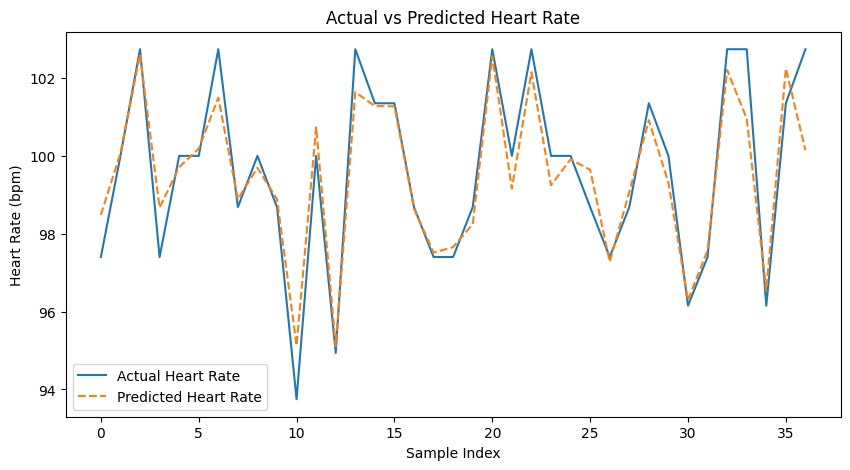

In [30]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Heart Rate')
plt.plot(y_pred, label='Predicted Heart Rate', linestyle='--')
plt.title('Actual vs Predicted Heart Rate')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.show()